In [1]:
import numpy as np
import pandas as pd

# =========================
# 0) 데이터 로드/전처리
# =========================
file_name = "mt-10yr0901-new.csv"
df = pd.read_csv(file_name, header=None)
df.columns = [
    "Date", "Open", "High", "Low", "Close",
    "Index1", "Index2", "Index3", "Index4", "Index5",
    "Index6", "Index7", "Index8", "Index9", "Index10", "Index11"
]
df["Date"] = pd.to_datetime(df["Date"]).dt.normalize()

def pct_change_today_over_yday(df, cur_col, prev_col):
    return (df[cur_col] / df[prev_col].shift(1) - 1) * 100

df["Open_Pct_Change"] = pct_change_today_over_yday(df, "Open", "Close")

# 각 지표별 전일 대비 변동률 (요구하신 정의 그대로)
for i in range(1, 12):
    col = f"Index{i}_Pct_Change"
    base = f"Index{i}"
    df[col] = pct_change_today_over_yday(df, base, base)

# (필요하면) NaN 제거
# df = df.dropna(subset=["Open_Pct_Change"] + [f"Index{i}_Pct_Change" for i in range(1,12)]).reset_index(drop=True)

# =========================
# 1) 공통 벡터 준비
# =========================
openv  = df["Open"].to_numpy(float)
closev = df["Close"].to_numpy(float)
opct   = df["Open_Pct_Change"].to_numpy(float)

close_minus_open = closev - openv
open_minus_close = openv - closev

rising_rate  = 2.460
falling_rate = 2.520

# =========================
# 2) 배치(Chunk) 벡터화 최적화 함수
#    - 부등호: 기존 그대로(엄격)
#    - 간극: 0.01 그대로
#    - 큰 구간은 chunk_size로 나누어 안전하게 계산
# =========================
def argmax_over_thresholds(
    a: np.ndarray,
    side: str,              # "rising_min"|"rising_max"|"falling_min"|"falling_max"
    start: float, stop: float, step: float,
    chunk_size: int = 200
):
    # 미리 공통 비교값과 기여치 계산
    if "rising" in side:
        adj = a * rising_rate
        cmp = opct - adj
        contrib = np.where(cmp > 0, close_minus_open, np.where(cmp < 0, open_minus_close, 0.0))
        pos_mask = (a > 0)
    else:
        adj = a * falling_rate
        cmp = opct - adj
        contrib = np.where(cmp < 0, open_minus_close, np.where(cmp > 0, close_minus_open, 0.0))
        neg_mask = (a < 0)

    thresholds = np.arange(start, stop, step, dtype=float)
    best_thr = None
    best_val = -np.inf

    # 배치 루프
    for s in range(0, len(thresholds), chunk_size):
        thr_chunk = thresholds[s:s+chunk_size]  # shape: (M,)
        # 각 행(a) vs 각 임계(thr_chunk) 비교 행렬을 만들되, 불리언만 유지해 메모리 절약
        if side == "rising_min":
            # 조건: a > 0 AND a > thr
            mask = (a[:, None] > thr_chunk[None, :]) & pos_mask[:, None]
        elif side == "rising_max":
            # 조건: a > 0 AND a < thr
            mask = (a[:, None] < thr_chunk[None, :]) & pos_mask[:, None]
        elif side == "falling_min":
            # 조건: a < 0 AND a > thr (thr는 음수 구간)
            mask = (a[:, None] > thr_chunk[None, :]) & neg_mask[:, None]
        else:  # "falling_max"
            # 조건: a < 0 AND a < thr
            mask = (a[:, None] < thr_chunk[None, :]) & neg_mask[:, None]

        # 각 임계별 총 수익 = sum(mask * contrib)
        # (contrib[:, None]을 곱한 뒤 축(0)으로 합)
        chunk_profit = (mask * contrib[:, None]).sum(axis=0).astype(float)

        # 배치 내 최댓값 갱신
        local_idx = int(np.argmax(chunk_profit))
        local_val = float(chunk_profit[local_idx])
        if local_val > best_val:
            best_val = local_val
            best_thr = float(thr_chunk[local_idx])

    return best_thr, best_val

def optimize_for_index(a: np.ndarray):
    # 네 구간 최적화 (간극 0.01 동일)
    rmin_thr, rmin_val = argmax_over_thresholds(a, "rising_min",   0.0,  0.5,  0.01)
    rmax_thr, rmax_val = argmax_over_thresholds(a, "rising_max",   0.5,  20.0, 0.01)
    fmin_thr, fmin_val = argmax_over_thresholds(a, "falling_min", -20.0, -0.5, 0.01)
    fmax_thr, fmax_val = argmax_over_thresholds(a, "falling_max",  -0.5,  0.0, 0.01)
    return {
        "rising_min":  (rmin_thr, rmin_val),
        "rising_max":  (rmax_thr, rmax_val),
        "falling_min": (fmin_thr, fmin_val),
        "falling_max": (fmax_thr, fmax_val),
    }

# =========================
# 3) Index1~11 전체 최적화
# =========================
results = {}
for i in range(1, 12):
    a = df[f"Index{i}_Pct_Change"].to_numpy(float)
    res = optimize_for_index(a)
    results[f"Index{i}"] = res

# =========================
# 4) 결과 출력
# =========================
for k, res in results.items():
    print(f"\n=== {k} ===")
    print(f"Rising Min : thr={res['rising_min'][0]:.2f}, profit={res['rising_min'][1]:.2f}")
    print(f"Rising Max : thr={res['rising_max'][0]:.2f}, profit={res['rising_max'][1]:.2f}")
    print(f"Falling Min: thr={res['falling_min'][0]:.2f}, profit={res['falling_min'][1]:.2f}")
    print(f"Falling Max: thr={res['falling_max'][0]:.2f}, profit={res['falling_max'][1]:.2f}")



=== Index1 ===
Rising Min : thr=0.47, profit=-24.55
Rising Max : thr=0.57, profit=-16.41
Falling Min: thr=-0.51, profit=-4.92
Falling Max: thr=-0.29, profit=-13.84

=== Index2 ===
Rising Min : thr=0.48, profit=-24.82
Rising Max : thr=0.57, profit=-14.36
Falling Min: thr=-0.51, profit=-7.92
Falling Max: thr=-0.47, profit=-16.72

=== Index3 ===
Rising Min : thr=0.48, profit=-26.96
Rising Max : thr=0.52, profit=-18.05
Falling Min: thr=-0.68, profit=-11.53
Falling Max: thr=-0.47, profit=-11.79

=== Index4 ===
Rising Min : thr=0.49, profit=-19.90
Rising Max : thr=0.61, profit=-11.38
Falling Min: thr=-0.64, profit=-2.73
Falling Max: thr=-0.25, profit=-11.55

=== Index5 ===
Rising Min : thr=0.42, profit=-21.62
Rising Max : thr=0.54, profit=-13.54
Falling Min: thr=-0.74, profit=-13.10
Falling Max: thr=-0.46, profit=-10.01

=== Index6 ===
Rising Min : thr=0.02, profit=52.97
Rising Max : thr=1.31, profit=49.33
Falling Min: thr=-1.05, profit=71.17
Falling Max: thr=-0.01, profit=69.26

=== Index7

In [ ]:
import numpy as np
import pandas as pd

# =========================
# 0) 데이터 로드/전처리
# =========================
file_name = "mt-10yr0901-new.csv"
df = pd.read_csv(file_name, header=None)
df.columns = [
    "Date", "Open", "High", "Low", "Close",
    "Index1", "Index2", "Index3", "Index4", "Index5",
    "Index6", "Index7", "Index8", "Index9", "Index10", "Index11"
]
df["Date"] = pd.to_datetime(df["Date"]).dt.normalize()
df = df.sort_values("Date").reset_index(drop=True)

def pct_change_today_over_yday(df, cur_col, prev_col):
    return (df[cur_col] / df[prev_col].shift(1) - 1) * 100

# (시가 / 전일 종가 - 1) * 100
df["Open_Pct_Change"] = pct_change_today_over_yday(df, "Open", "Close")

# 각 지표별 전일 대비 변동률 (요구하신 정의 그대로)
for i in range(1, 12):
    base = f"Index{i}"
    df[f"Index{i}_Pct_Change"] = pct_change_today_over_yday(df, base, base)

# =========================
# 1) 공통 벡터 준비
# =========================
openv  = df["Open"].to_numpy(float)
closev = df["Close"].to_numpy(float)
opct   = df["Open_Pct_Change"].to_numpy(float)

close_minus_open = closev - openv
open_minus_close = openv - closev

# 파라미터(기존과 동일)
rising_rate  = 2.460
falling_rate = 2.520

# =========================
# 2) 임계 탐색(배치 벡터화, 간극 0.01, 엄격부등호 유지)
# =========================
def argmax_over_thresholds(
    a: np.ndarray,
    side: str,              # "rising_min"|"rising_max"|"falling_min"|"falling_max"
    start: float, stop: float, step: float,
    chunk_size: int = 200
):
    # 공통 기여치 (임계와 무관)
    if "rising" in side:
        adj = a * rising_rate
        cmp = opct - adj
        contrib = np.where(cmp > 0, close_minus_open, np.where(cmp < 0, open_minus_close, 0.0))
        pos_mask = (a > 0)
    else:
        adj = a * falling_rate
        cmp = opct - adj
        contrib = np.where(cmp < 0, open_minus_close, np.where(cmp > 0, close_minus_open, 0.0))
        neg_mask = (a < 0)

    thresholds = np.arange(start, stop, step, dtype=float)
    best_thr = None
    best_val = -np.inf

    for s in range(0, len(thresholds), chunk_size):
        thr_chunk = thresholds[s:s+chunk_size]
        if side == "rising_min":
            mask = (a[:, None] > thr_chunk[None, :]) & pos_mask[:, None]    # a > 0 AND a > thr
        elif side == "rising_max":
            mask = (a[:, None] < thr_chunk[None, :]) & pos_mask[:, None]    # a > 0 AND a < thr
        elif side == "falling_min":
            mask = (a[:, None] > thr_chunk[None, :]) & neg_mask[:, None]    # a < 0 AND a > thr
        else:  # "falling_max"
            mask = (a[:, None] < thr_chunk[None, :]) & neg_mask[:, None]    # a < 0 AND a < thr

        chunk_profit = (mask * contrib[:, None]).sum(axis=0).astype(float)
        local_idx = int(np.argmax(chunk_profit))
        local_val = float(chunk_profit[local_idx])
        if local_val > best_val:
            best_val = local_val
            best_thr = float(thr_chunk[local_idx])

    return best_thr, best_val

def optimize_for_index(a: np.ndarray):
    rmin_thr, rmin_val = argmax_over_thresholds(a, "rising_min",   0.0,  0.5,  0.005)
    rmax_thr, rmax_val = argmax_over_thresholds(a, "rising_max",   0.5,  1.5, 0.005)
    fmin_thr, fmin_val = argmax_over_thresholds(a, "falling_min", -1.5, -0.5, 0.005)
    fmax_thr, fmax_val = argmax_over_thresholds(a, "falling_max",  -0.5,  0.0, 0.005)
    return {
        "rising_min":  (rmin_thr, rmin_val),
        "rising_max":  (rmax_thr, rmax_val),
        "falling_min": (fmin_thr, fmin_val),
        "falling_max": (fmax_thr, fmax_val),
    }

# =========================
# 3) 구간 내 실제 PnL 계산 (최종 백테스트에 사용)
#    - 엄격부등호 유지
# =========================
def daily_pnl_from_intervals(a: np.ndarray, rmin: float, rmax: float, fmin: float, fmax: float) -> np.ndarray:
    # 상승 구간: a > 0 AND rmin < a < rmax
    pos_mask = (a > 0) & (a > rmin) & (a < rmax)
    adj_r = a * rising_rate
    cmp_r = opct - adj_r
    contrib_r = np.where(cmp_r > 0, close_minus_open, np.where(cmp_r < 0, open_minus_close, 0.0))
    pnl_r = np.where(pos_mask, contrib_r, 0.0)

    # 하락 구간: a < 0 AND fmin < a < fmax  (fmin,fmax는 음수 범위)
    neg_mask = (a < 0) & (a > fmin) & (a < fmax)
    adj_f = a * falling_rate
    cmp_f = opct - adj_f
    contrib_f = np.where(cmp_f < 0, open_minus_close, np.where(cmp_f > 0, close_minus_open, 0.0))
    pnl_f = np.where(neg_mask, contrib_f, 0.0)

    return pnl_r + pnl_f  # 일자별 총 PnL

# =========================
# 4) 지표별 최적화 + 최종 백테스트 (일자별 PnL)
# =========================
results = {}
daily_pnls = {}  # 지표별 일자별 PnL (np.ndarray)

for i in range(1, 12):
    a = df[f"Index{i}_Pct_Change"].to_numpy(float)
    res = optimize_for_index(a)
    results[f"Index{i}"] = res

    rmin, _ = res["rising_min"]
    rmax, _ = res["rising_max"]
    fmin, _ = res["falling_min"]
    fmax, _ = res["falling_max"]

    pnl = daily_pnl_from_intervals(a, rmin, rmax, fmin, fmax)
    daily_pnls[f"Index{i}"] = pnl

# =========================
# 5) 리포팅: 임계/구간 수익/토탈 수익
# =========================
def profit_rising_interval(a: np.ndarray, rmin: float, rmax: float) -> float:
    pos_mask = (a > 0) & (a > rmin) & (a < rmax)
    adj = a * rising_rate
    cmp = opct - adj
    contrib = np.where(cmp > 0, close_minus_open, np.where(cmp < 0, open_minus_close, 0.0))
    return float(np.sum(np.where(pos_mask, contrib, 0.0)))

def profit_falling_interval(a: np.ndarray, fmin: float, fmax: float) -> float:
    neg_mask = (a < 0) & (a > fmin) & (a < fmax)
    adj = a * falling_rate
    cmp = opct - adj
    contrib = np.where(cmp < 0, open_minus_close, np.where(cmp > 0, close_minus_open, 0.0))
    return float(np.sum(np.where(neg_mask, contrib, 0.0)))

for i in range(1, 12):
    key = f"Index{i}"
    res = results[key]
    a = df[f"Index{i}_Pct_Change"].to_numpy(float)

    rmin_thr, rmin_val = res["rising_min"]
    rmax_thr, rmax_val = res["rising_max"]
    fmin_thr, fmin_val = res["falling_min"]
    fmax_thr, fmax_val = res["falling_max"]

    rising_interval_profit  = profit_rising_interval(a, rmin_thr, rmax_thr)
    falling_interval_profit = profit_falling_interval(a, fmin_thr, fmax_thr)
    total_profit = rising_interval_profit + falling_interval_profit

    print(f"\n=== {key} ===")
    print(f"Rising Min : thr={rmin_thr:.2f}, profit={rmin_val:.2f}")
    print(f"Rising Max : thr={rmax_thr:.2f}, profit={rmax_val:.2f}")
    print(f"Falling Min: thr={fmin_thr:.2f}, profit={fmin_val:.2f}")
    print(f"Falling Max: thr={fmax_thr:.2f}, profit={fmax_val:.2f}")
    print(f"total profit = {total_profit:.2f}  "
          f"(= rising({rmin_thr:.2f},{rmax_thr:.2f}) + falling({fmin_thr:.2f},{fmax_thr:.2f}))")

# =========================
# 6) 최종 백테스트 성과: 연/월 수익, 에쿼티, MDD
# =========================
date_index = df["Date"]

def to_series(pnl_np: np.ndarray, name: str) -> pd.Series:
    s = pd.Series(pnl_np, index=date_index, name=name)
    return s.fillna(0.0)

# (a) 지표별 일자 수익 시리즈 & (선택) 종합 포트폴리오
daily_pnl_df = pd.DataFrame({k: to_series(v, k) for k, v in daily_pnls.items()})
daily_pnl_df["Portfolio(EqualWeight)"] = daily_pnl_df.mean(axis=1)  # 11개 지표 동일 가중

# (b) 누적 에쿼티
equity_df = daily_pnl_df.cumsum()

# (c) 월/연 수익 (경고 제거: 'ME', 'YE' 사용)
monthly_pnl = daily_pnl_df.resample("ME").sum()
yearly_pnl  = daily_pnl_df.resample("YE").sum()

print("\n===== YEARLY PnL (지표별 & Equal-Weight 포트폴리오) =====")
print(yearly_pnl.astype(float).round(2))

print("\n===== MONTHLY PnL (마지막 12개월) =====")
print(monthly_pnl.tail(12).astype(float).round(2))

# (d) MDD 계산 함수 (초기자본 기준)
def max_drawdown(equity_pnl: pd.Series, initial_capital: float = 100.0):
    """
    equity_pnl: 누적 PnL 시리즈 (포지션 에쿼티가 아님).
    내부에서 initial_capital을 더해 '자본 기준 에쿼티'로 변환 후 MDD 계산.
    """
    eq = initial_capital + equity_pnl
    running_max = eq.cummax()

    drawdown = running_max - eq                           # 절대 낙폭
    dd_ratio = drawdown / running_max.clip(lower=1e-12)   # 퍼센트 낙폭 (0 나눗셈 방지)

    trough_date = dd_ratio.idxmax()
    peak_date = eq.loc[:trough_date].idxmax() if not eq.loc[:trough_date].empty else eq.index[0]

    mdd_abs = float(drawdown.loc[trough_date])
    mdd_pct = float(dd_ratio.loc[trough_date])  # 0~1

    peak_val = float(eq.loc[peak_date])
    recovery_date = eq.loc[trough_date:].where(lambda x: x >= peak_val).first_valid_index()

    return {
        "MDD": mdd_abs,
        "MDD_pct": mdd_pct,
        "peak_date": peak_date,
        "trough_date": trough_date,
        "recovery_date": recovery_date
    }

# (e) 각 시리즈별 MDD 리포트
mdd_report = {}
for col in daily_pnl_df.columns:
    # equity_df[col]은 '누적 PnL' 이므로 함수 안에서 initial_capital 더해서 계산
    mdd_report[col] = max_drawdown(equity_df[col], initial_capital=100.0)

print("\n===== MDD REPORT =====")
for k, v in mdd_report.items():
    mdd_abs = f"{v['MDD']:,.2f}"
    mdd_pct = f"{v['MDD_pct']*100:.2f}%"
    peak = v["peak_date"].date()
    trough = v["trough_date"].date()
    recovery = v["recovery_date"].date() if v["recovery_date"] is not None else "None"
    print(f"{k:>22} | MDD={mdd_abs} ({mdd_pct}) | Peak={peak} → Trough={trough} → Recovery={recovery}")

# =========================
# 8) 가중치 최적화 (월별 리밸런싱)
# =========================

# (a) Equal Weight (이미 있음)
equal_weight_daily = daily_pnl_df[[f"Index{i}" for i in range(1,12)]].mean(axis=1)
daily_pnl_df["Portfolio(EqualWeight)"] = equal_weight_daily

# (b) Risk Parity (월별 리밸런싱)
# 방법: 매월 시작 시점 기준으로 과거 60일(or 3개월) 변동성 추정 → 1/vol 로 가중치 설정
lookback = 60

weights_rp = {}
rp_returns = []

for date, group in daily_pnl_df.resample("M"):
    start_idx = group.index[0]
    end_idx   = group.index[-1]

    # 과거 60일 변동성 추정
    hist = daily_pnl_df.loc[:start_idx].iloc[-lookback:]
    vols = hist.std()

    # Risk Parity: 1/σ 비례, 정규화
    inv_vol = 1 / vols.replace(0, np.nan)
    w = inv_vol / inv_vol.sum()
    weights_rp[start_idx] = w

    # 해당월 수익
    monthly_ret = (daily_pnl_df.loc[start_idx:end_idx] * w).sum(axis=1)
    rp_returns.append(monthly_ret)

# Risk Parity 포트폴리오 수익 시리즈
rp_returns = pd.concat(rp_returns).sort_index()
daily_pnl_df["Portfolio(RiskParity)"] = rp_returns

# =========================
# 9) 성과지표 함수 (Sharpe, 승률, 연환산 변동성 등)
# =========================

def performance_metrics(pnl_series: pd.Series, periods_per_year=252):
    """
    pnl_series : 일별 손익(Series)
    """
    ret = pnl_series
    mean_daily = ret.mean()
    std_daily  = ret.std()

    sharpe = (mean_daily / std_daily) * np.sqrt(periods_per_year) if std_daily != 0 else np.nan
    win_rate = (ret > 0).mean() * 100
    ann_vol  = std_daily * np.sqrt(periods_per_year)
    cum_pnl  = ret.cumsum().iloc[-1]

    return {
        "CumulativePnL": cum_pnl,
        "Sharpe": sharpe,
        "WinRate(%)": win_rate,
        "AnnVol": ann_vol,
        "DailyMean": mean_daily,
        "DailyStd": std_daily
    }

# =========================
# 10) 성과 리포트 출력
# =========================

perf_report = {}
for col in daily_pnl_df.columns:
    perf_report[col] = performance_metrics(daily_pnl_df[col])

perf_df = pd.DataFrame(perf_report).T.round(3)

print("\n===== PERFORMANCE METRICS =====")
print(perf_df)

# =========================
# (선택) CSV 저장
# =========================
perf_df.to_csv("performance_metrics.csv", encoding="utf-8-sig")


# =========================
# (선택) CSV 저장
# =========================
# daily_pnl_df.to_csv("daily_pnl_by_index.csv", index_label="Date", encoding="utf-8-sig")
# equity_df.to_csv("equity_by_index.csv", index_label="Date", encoding="utf-8-sig")
# monthly_pnl.to_csv("monthly_pnl.csv", index_label="Date", encoding="utf-8-sig")
# yearly_pnl.to_csv("yearly_pnl.csv", index_label="Date", encoding="utf-8-sig")



=== Index1 ===
Rising Min : thr=0.47, profit=-24.55
Rising Max : thr=0.57, profit=-16.41
Falling Min: thr=-0.51, profit=-4.92
Falling Max: thr=-0.29, profit=-13.84
total profit = 4.26  (= rising(0.47,0.57) + falling(-0.51,-0.29))

=== Index2 ===
Rising Min : thr=0.48, profit=-24.82
Rising Max : thr=0.57, profit=-14.36
Falling Min: thr=-0.51, profit=-7.92
Falling Max: thr=-0.47, profit=-16.72
total profit = 2.75  (= rising(0.48,0.57) + falling(-0.51,-0.47))

=== Index3 ===
Rising Min : thr=0.48, profit=-26.96
Rising Max : thr=0.52, profit=-18.05
Falling Min: thr=-0.68, profit=-11.53
Falling Max: thr=-0.47, profit=-11.79
total profit = 6.87  (= rising(0.48,0.52) + falling(-0.68,-0.47))

=== Index4 ===
Rising Min : thr=0.49, profit=-19.90
Rising Max : thr=0.61, profit=-11.38
Falling Min: thr=-0.64, profit=-2.73
Falling Max: thr=-0.25, profit=-11.55
total profit = 15.29  (= rising(0.49,0.61) + falling(-0.64,-0.25))

=== Index5 ===
Rising Min : thr=0.42, profit=-21.62
Rising Max : thr=0.54

C:\Users\user\AppData\Local\Temp\ipykernel_35280\2847633904.py:263: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for date, group in daily_pnl_df.resample("M"):


In [8]:
import numpy as np
import pandas as pd

# =========================
# 0) 데이터 로드/전처리
# =========================
file_name = "mt-10yr0901-new.csv"
df = pd.read_csv(file_name, header=None)
df.columns = [
    "Date", "Open", "High", "Low", "Close",
    "Index1", "Index2", "Index3", "Index4", "Index5",
    "Index6", "Index7", "Index8", "Index9", "Index10", "Index11"
]
df["Date"] = pd.to_datetime(df["Date"]).dt.normalize()
df = df.sort_values("Date").reset_index(drop=True)

def pct_change_today_over_yday(df, cur_col, prev_col):
    return (df[cur_col] / df[prev_col].shift(1) - 1) * 100

# (시가 / 전일 종가 - 1) * 100
df["Open_Pct_Change"] = pct_change_today_over_yday(df, "Open", "Close")

# 각 지표별 전일 대비 변동률 (요구하신 정의 그대로)
for i in range(1, 12):
    base = f"Index{i}"
    df[f"Index{i}_Pct_Change"] = pct_change_today_over_yday(df, base, base)

# =========================
# 1) 공통 벡터 준비
# =========================
openv  = df["Open"].to_numpy(float)
closev = df["Close"].to_numpy(float)
opct   = df["Open_Pct_Change"].to_numpy(float)

close_minus_open = closev - openv
open_minus_close = openv - closev

# =========================
# 2) 최적화된 파라미터로 적용 (Index7의 최적 상승/하락 조정률)
# =========================
# Index7 파라미터 값
rising_rate = 1.810  # 최적 상승 조정률
falling_rate = 4.025  # 최적 하락 조정률

# =========================
# 3) 임계 탐색 및 PnL 계산 (Index7 적용)
# =========================
def argmax_over_thresholds(
    a: np.ndarray,
    side: str,              # "rising_min"|"rising_max"|"falling_min"|"falling_max"
    start: float, stop: float, step: float,
    chunk_size: int = 200
):
    if "rising" in side:
        adj = a * rising_rate
        cmp = opct - adj
        contrib = np.where(cmp > 0, close_minus_open, np.where(cmp < 0, open_minus_close, 0.0))
        pos_mask = (a > 0)
    else:
        adj = a * falling_rate
        cmp = opct - adj
        contrib = np.where(cmp < 0, open_minus_close, np.where(cmp > 0, close_minus_open, 0.0))
        neg_mask = (a < 0)

    thresholds = np.arange(start, stop, step, dtype=float)
    best_thr = None
    best_val = -np.inf

    for s in range(0, len(thresholds), chunk_size):
        thr_chunk = thresholds[s:s+chunk_size]
        if side == "rising_min":
            mask = (a[:, None] > thr_chunk[None, :]) & pos_mask[:, None]
        elif side == "rising_max":
            mask = (a[:, None] < thr_chunk[None, :]) & pos_mask[:, None]
        elif side == "falling_min":
            mask = (a[:, None] > thr_chunk[None, :]) & neg_mask[:, None]
        else:  # "falling_max"
            mask = (a[:, None] < thr_chunk[None, :]) & neg_mask[:, None]

        chunk_profit = (mask * contrib[:, None]).sum(axis=0).astype(float)
        local_idx = int(np.argmax(chunk_profit))
        local_val = float(chunk_profit[local_idx])
        if local_val > best_val:
            best_val = local_val
            best_thr = float(thr_chunk[local_idx])

    return best_thr, best_val

def optimize_for_index(a: np.ndarray):
    rmin_thr, rmin_val = argmax_over_thresholds(a, "rising_min",   0.0,  0.5,  0.005)
    rmax_thr, rmax_val = argmax_over_thresholds(a, "rising_max",   0.5,  1.5, 0.005)
    fmin_thr, fmin_val = argmax_over_thresholds(a, "falling_min", -1.4, -0.5, 0.005)
    fmax_thr, fmax_val = argmax_over_thresholds(a, "falling_max",  -0.5,  0.0, 0.005)
    return {
        "rising_min":  (rmin_thr, rmin_val),
        "rising_max":  (rmax_thr, rmax_val),
        "falling_min": (fmin_thr, fmin_val),
        "falling_max": (fmax_thr, fmax_val),
    }

def daily_pnl_from_intervals(a: np.ndarray, rmin: float, rmax: float, fmin: float, fmax: float) -> np.ndarray:
    # 상승 구간: a > 0 AND rmin < a < rmax
    pos_mask = (a > 0) & (a > rmin) & (a < rmax)
    adj_r = a * rising_rate
    cmp_r = opct - adj_r
    contrib_r = np.where(cmp_r > 0, close_minus_open, np.where(cmp_r < 0, open_minus_close, 0.0))
    pnl_r = np.where(pos_mask, contrib_r, 0.0)

    # 하락 구간: a < 0 AND fmin < a < fmax
    neg_mask = (a < 0) & (a > fmin) & (a < fmax)
    adj_f = a * falling_rate
    cmp_f = opct - adj_f
    contrib_f = np.where(cmp_f < 0, open_minus_close, np.where(cmp_f > 0, close_minus_open, 0.0))
    pnl_f = np.where(neg_mask, contrib_f, 0.0)

    return pnl_r + pnl_f  # 일자별 총 PnL

# =========================
# 4) 결과: Index7 최적화 + PnL 계산
# =========================
index7_data = df["Index7_Pct_Change"].to_numpy(float)
res = optimize_for_index(index7_data)

rmin, _ = res["rising_min"]
rmax, _ = res["rising_max"]
fmin, _ = res["falling_min"]
fmax, _ = res["falling_max"]

# PnL 계산
pnl_index7 = daily_pnl_from_intervals(index7_data, rmin, rmax, fmin, fmax)

# =========================
# 5) 최적화 결과 출력
# =========================
print("\n=== Index7 최적화 결과 ===")
print(f"최적 상승 조정률 (rising_rate) = {rising_rate:.3f}")
print(f"최적 하락 조정률 (falling_rate) = {falling_rate:.3f}")
print(f"Rising Min : thr={rmin:.2f}, profit={rmin_val:.2f}")
print(f"Rising Max : thr={rmax:.2f}, profit={rmax_val:.2f}")
print(f"Falling Min: thr={fmin:.2f}, profit={fmin_val:.2f}")
print(f"Falling Max: thr={fmax:.2f}, profit={fmax_val:.2f}")
total_profit = rmin_val + rmax_val + fmin_val + fmax_val
print(f"total profit = {total_profit:.2f}")

# =========================
# 6) MDD 계산 함수
# =========================
date_index = df["Date"]
def to_series(pnl_np: np.ndarray, name: str) -> pd.Series:
    s = pd.Series(pnl_np, index=date_index, name=name)
    return s.fillna(0.0)

daily_pnl_df = pd.DataFrame({f"Index7": to_series(pnl_index7, "Index7")})
daily_pnl_df["Portfolio(EqualWeight)"] = daily_pnl_df.mean(axis=1)  # 11개 지표 동일 가중

# 누적 에쿼티
equity_df = daily_pnl_df.cumsum()

monthly_pnl = daily_pnl_df.resample("ME").sum()
yearly_pnl  = daily_pnl_df.resample("YE").sum()

print("\n===== YEARLY PnL (Index7 최적화) =====")
print(yearly_pnl.astype(float).round(2))

print("\n===== MONTHLY PnL (마지막 12개월) =====")
print(monthly_pnl.tail(12).astype(float).round(2))



=== Index7 최적화 결과 ===
최적 상승 조정률 (rising_rate) = 1.810
최적 하락 조정률 (falling_rate) = 4.025
Rising Min : thr=0.04, profit=3.53
Rising Max : thr=1.14, profit=-14.74
Falling Min: thr=-1.40, profit=-4.66
Falling Max: thr=-0.01, profit=5.59
total profit = -10.28

===== YEARLY PnL (Index7 최적화) =====
            Index7  Portfolio(EqualWeight)
Date                                      
2011-12-31   -5.67                   -5.67
2012-12-31    6.83                    6.83
2013-12-31    7.33                    7.33
2014-12-31    5.76                    5.76
2015-12-31   11.60                   11.60
2016-12-31    9.89                    9.89
2017-12-31    6.66                    6.66
2018-12-31    7.11                    7.11
2019-12-31   12.16                   12.16
2020-12-31   10.54                   10.54
2021-12-31    8.22                    8.22
2022-12-31   23.57                   23.57
2023-12-31   12.12                   12.12
2024-12-31   -5.53                   -5.53
2025-12-31    3.03  

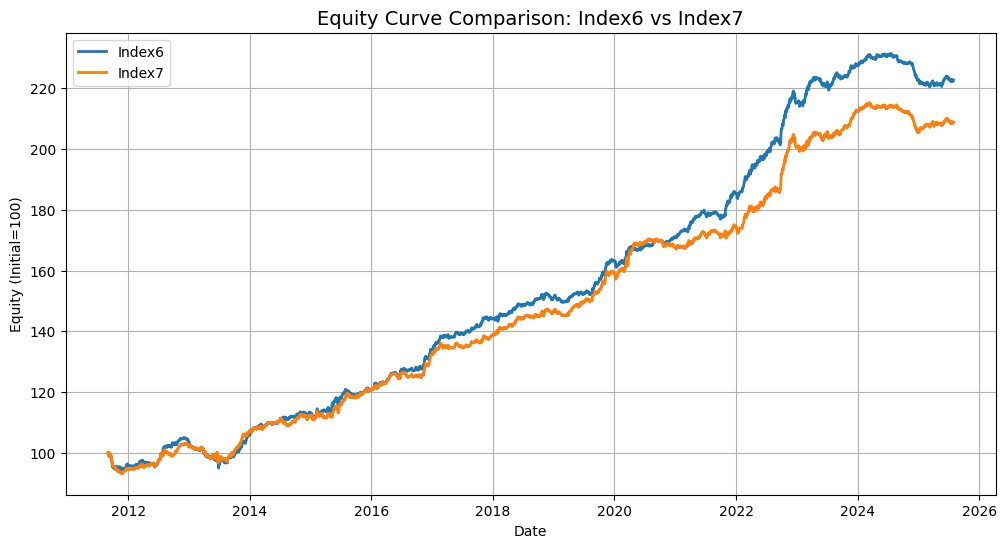

In [7]:
import matplotlib.pyplot as plt

# Index6, Index7 누적 에쿼티 (자본 100 기준)
initial_capital = 100
eq6 = initial_capital + equity_df["Index6"]
eq7 = initial_capital + equity_df["Index7"]

plt.figure(figsize=(12,6))
plt.plot(eq6.index, eq6, label="Index6", linewidth=2)
plt.plot(eq7.index, eq7, label="Index7", linewidth=2)

plt.title("Equity Curve Comparison: Index6 vs Index7", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Equity (Initial=100)")
plt.legend()
plt.grid(True)
plt.show()